In [1]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QUANTAXIS as QA

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import EAST.Fetcher_EM as east

from base.JuUnits import excute_for_multidates

E:\PyProjects\IndicatorLab\EAST\Crawler_Block_East.py:41: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2020'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [139]:
# df_all1 = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all2 = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all = pd.concat([df_all1,df_all2],axis=0).sort_index()

data_ = df_all

year1 = '2016'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [140]:
# 个股情绪

# turnover = data_['volume'] / (data_['lshares'] *100) 

# turnover_mean_month = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level='code')
# turnover_mean_week = excute_for_multidates(turnover, lambda x:x.rolling(5).mean(), level='code')
# turnover_unknown = turnover_mean_week/turnover_mean_month

# overnight_ret = excute_for_multidates(data_, lambda x:(x['open']/x['close'].shift(1))-1, level='code')
# turnover_rate = excute_for_multidates(turnover, lambda x: x-x.shift(1), level='code')
# # 指令不平衡(净流入额/总成交额)  代理达成一致意见所需时间
# buy_sell_belance = intraday_df_tmp['bs_balance']

# ret = smpl.get_current_return(data_, 'close')
# ret_std5 = excute_for_multidates(ret, lambda x:x.rolling(5).std(), level='code')

def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        rs = float(x.shape[0])
    else:
        up = (x>0).sum()
        rs = up/down
    rsi=100-100/(1+rs)
    return rsi
    
# *投资者达成一致意见所需时间 = (最高价 - 开盘价) / (收盘价 - 开盘价)
# *相对强弱指标（RSI）：计算公式：RSI=100-100/(1+RS)
   # 相对强度(RS)=一定时期收盘指数涨数的平均值/一定时期收盘指数跌数的平均值，主要和价格的收盘平均值有关，可以表现股价的运动速率。

# RSI_6 = excute_for_multidates(ret, lambda x:x.rolling(6).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_12 = excute_for_multidates(ret, lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_CD = RS_6-RS_12

# *随机指标（KD）
# C为当天的收；
# UP:=HHV(H,20);
# DN:=LLV(L,20);
# RSV:=(C-DN)/(UP-DN)*100;
# K:SMA(RSV,3,1);
# D:SMA(K,3,1);

def calc_kd(df):
    up = df.high.rolling(20).max()
    dn = df.low.rolling(20).min()
    c = df.close
    rsv = (c-dn)/(up-dn) * 100
    return rsv
    
KD = excute_for_multidates(data_, lambda xs:calc_kd(xs), level='code')



# volume





In [141]:
# KD[20:60]

In [142]:
# RSI_CD[24200:24260]

In [143]:
def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        return float(x.shape[0])
    else:
        up = (x>0).sum()
        return up/down
    
excute_for_multidates(ret.loc[(slice(None),'000002'),], lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')

NameError: name 'ret' is not defined

In [ ]:
def get_intraday_indicator_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######指令平衡###########################
        #已实现方差 RealizedVolatility
        net_mf_amount = varaints_daily.amount[ret > 0].sum()
        neg_amount = varaints_daily.amount[ret < 0].sum()
        amount = neg_amount+net_mf_amount
        if amount == 0:
            bs_balance = 0
        else:
            bs_balance = (net_mf_amount/amount)-0.5
        ##########################################
        
        
        # print()
        return bs_balance

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['bs_balance'])
    
    return res_df

intraday_df_tmp = pd.DataFrame()
for code in ['002415']:
    res = get_intraday_indicator_by_code(code,dates.min().strftime('%Y-%m-%d'),dates.max().strftime('%Y-%m-%d'))
    if res is None:
        continue
    intraday_df_tmp = pd.concat([intraday_df_tmp,res],axis=0)

In [ ]:
# a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
# a = turnover_unknown.loc[(slice(None),'000001')]
a = KD.loc[(slice(None),'000002'),]
d = a.index.get_level_values(0).unique()
# bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data
bench = data_.loc[(slice(None),'000002'),]

In [ ]:
fig = plt.figure(figsize=(1420/72,320/72))
# a['close'].groupby(level=1).apply(lambda x:x.plot())
a.plot()
# ax2 = plt.gca()
# ax2.plot(range(bench.shape[0]),(0.5*a['close'].loc[(slice(None),'880876')].values+0.5*a['close'].loc[(slice(None),'880877')]).values,linewidth=2,color="red")



ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [ ]:
data_

In [ ]:
a.corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880811')]).corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880008')]).corr(a['close'].loc[(slice(None),'880018')])

In [ ]:
a

In [ ]:
a['close'].loc[(slice(None),'880780')]

In [ ]:
# 市场情绪
# n=east.fetch_north_deal_day(direct='north_', start=dates.min(), end=dates.max()).data
# s=east.fetch_north_deal_day(direct='south_', start=dates.min(), end=dates.max()).data
#~ 880780 融资增加 2019开始
#~ 880792 基金增仓 2020
#~ 880793 基金减仓 2020
#~ 880751 昨日跌停# 880863  昨日涨停 # 880876 户数增加 # 880877 户数减少
#~ 880752 昨曾跌停# 880874  昨曾涨停
#~ 880008 全Ａ等权
#~ 880018 主板等权


# 880990 TDX 金融 
# 880005 涨跌家数 收=涨数，开=跌数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

# 4.简易市场情绪
# 每日涨停/跌停数

In [ ]:
a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
d = a.index.get_level_values(0).unique()
bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data

fig = plt.figure(figsize=(1420/72,320/72))
a['close'].groupby(level=1).apply(lambda x:x.plot())


ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [19]:
c = data_.loc[(slice(None),'000002'),]
c_ret = smpl.get_current_return(c,'close').dropna()
c_ret_x = c_ret.shift(1).dropna().values
c_ret_y = c_ret[1:].values
c_ret_x = c_ret.shift(1).dropna().values.reshape(-1,1)
c_ret_y = c_ret[1:].values.reshape(-1,1)

# x_train,x_test, y_train, y_test =train_test_split(c_ret_x,c_ret_y,test_size=.1, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import time

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader

class time_series_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_stacked_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # batch_size = x.size(0)
        # h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_dim).requires_grad_()
        # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def lstm_train(data_loader, model_criterion_optimiser=None, 
               input_size=1, hidden_size=4, num_stacked_layers=1 ,output_size=1, learn_rate=0.01,
               historys=None, num_epochs=50, verbose=True):
    # input_size 输入的维度为1只有Close收盘价 
    # hidden_size 隐藏层特征的维度
    # num_stacked_layers 循环的layers
    # output_dim 预测后一天的收盘价

    if model_criterion_optimiser is None:
        model = LSTM(input_dim=input_size, hidden_dim=hidden_size, num_stacked_layers=num_stacked_layers,output_dim=output_size)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.Adam(model.parameters(), lr=learn_rate)
    else:
        model = model_criterion_optimiser[0]
        criterion = model_criterion_optimiser[1]
        optimiser = model_criterion_optimiser[2]
    
    start_time = time.time()
    model.train(True)
    for t in range(num_epochs):
        running_loss = .0
        for batch_index, batch in enumerate(data_loader):
            x_batch,y_batch = batch[0],batch[1]

            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if verbose:
                if batch_index == x_batch.shape[0]-1:
                    print("Batch {0} avgLoss: {1}".format(batch_index+1,running_loss/batch_size))
        if not historys is None:
            historys.append(running_loss)
        if verbose:
            if t%10==0:
                print("Epoch ", t, "MSE: ", running_loss)

    training_time = time.time() - start_time
    print("Training time: {}".format(training_time))
    return model,criterion,optimiser


def model_check_plot(model,criterion, x, y, historys=None):
    model.train(False)
    with torch.no_grad():
        predict = model(x)
        loss = criterion(predict, y)
        running_loss = loss.item()
    print("validate loss: {:.5f} ,avg loss: {:.8f}".format(loss.item(),loss.item()/len(x)))
    
    predict = pd.DataFrame(predict.numpy().squeeze())
    original = pd.DataFrame(y.numpy().squeeze())

    fig = plt.figure(figsize=(1620/72,420/72))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax = plt.plot(list(original.index), original.values, label="Data", color='royalblue')
    ax = plt.plot(list(predict.index), predict.values, label="Training Prediction (LSTM)", color='tomato')
    if not historys is None:
        ax3 = plt.gca().twinx()
        ax3 = plt.gca().twiny()
        ax3.plot(historys,linestyle=":", linewidth=1,color="black",label='bm')
    plt.show()
   




In [20]:
clo = c.close.values

lookback = 5
data_tmp = []
for i in range(len(clo)-5) :
    data_tmp.append(clo[i:i+lookback+1])
data_tmp = np.array(data_tmp)

x = data_tmp[:,:-1].reshape(-1,lookback,1)
x = torch.tensor(x).to(torch.float32)
y = data_tmp[:,-1].reshape(-1,1)
y = torch.tensor(y).to(torch.float32)
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=.1, shuffle=False)

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
    
train_dataset = time_series_dataset(x_train, y_train)
test_dataset = time_series_dataset(x_test, y_test)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




torch.Size([978, 5, 1]) torch.Size([978, 1]) torch.Size([109, 5, 1]) torch.Size([109, 1])


Training time: 26.94086480140686
validate loss: 0.31126 ,avg loss: 0.00031826


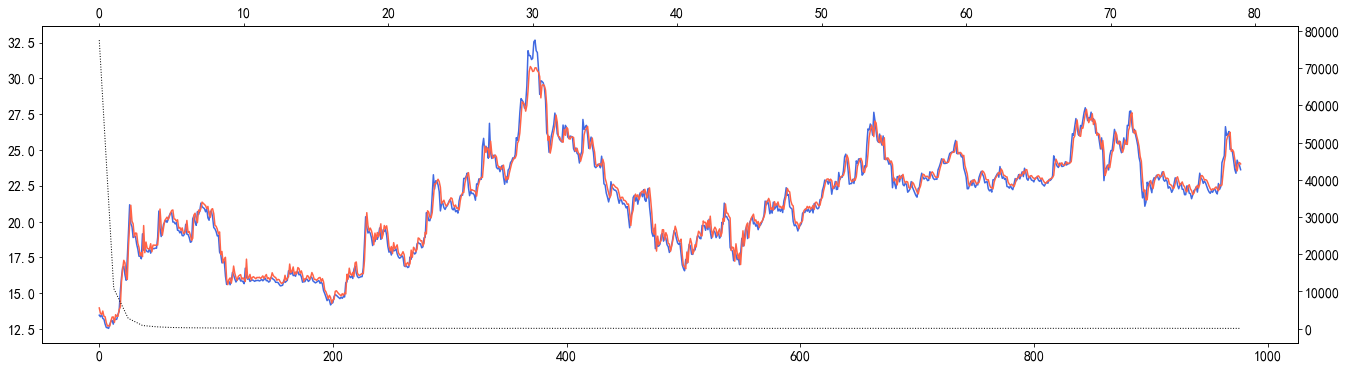

In [21]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=4, num_stacked_layers=1,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

Training time: 26.947524785995483
validate loss: 0.47843 ,avg loss: 0.00048919


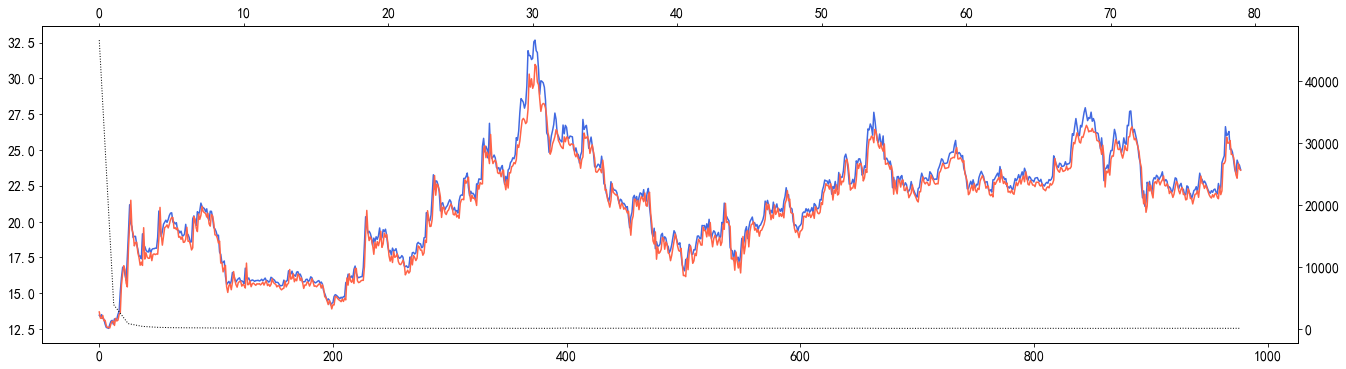

In [22]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=8, num_stacked_layers=1,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

Training time: 38.90087604522705
validate loss: 0.35431 ,avg loss: 0.00036228


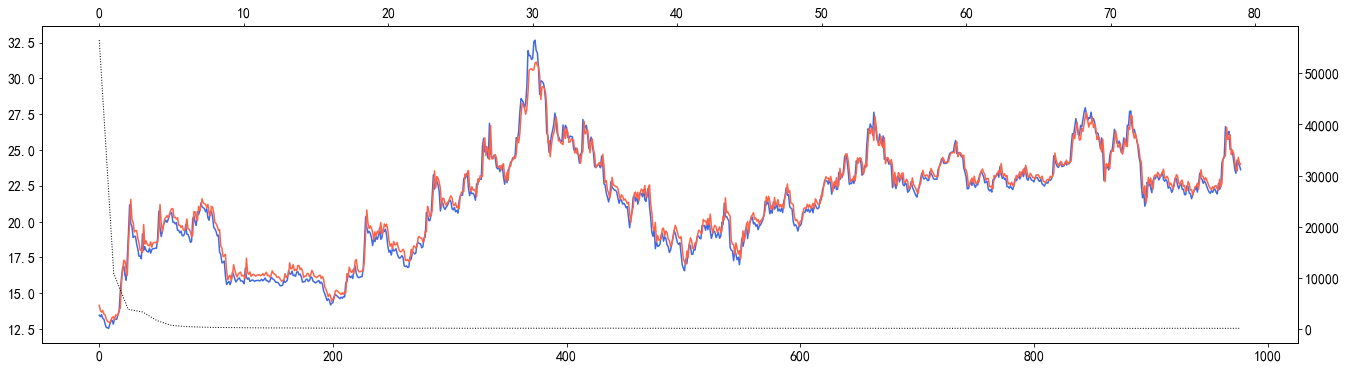

In [23]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=4, num_stacked_layers=2,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

Training time: 41.02258038520813
validate loss: 0.37490 ,avg loss: 0.00038333


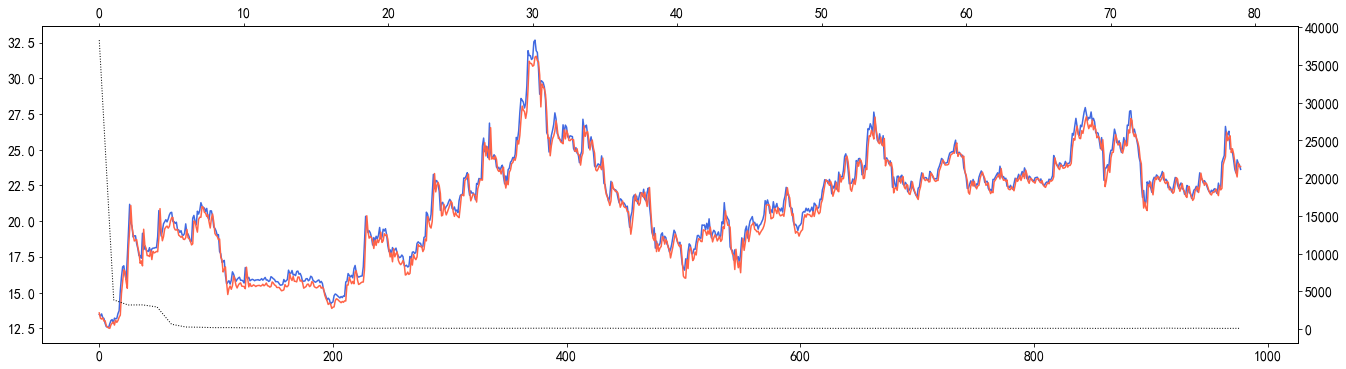

In [24]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=8, num_stacked_layers=2,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

Training time: 51.208794593811035
validate loss: 0.36304 ,avg loss: 0.00037120


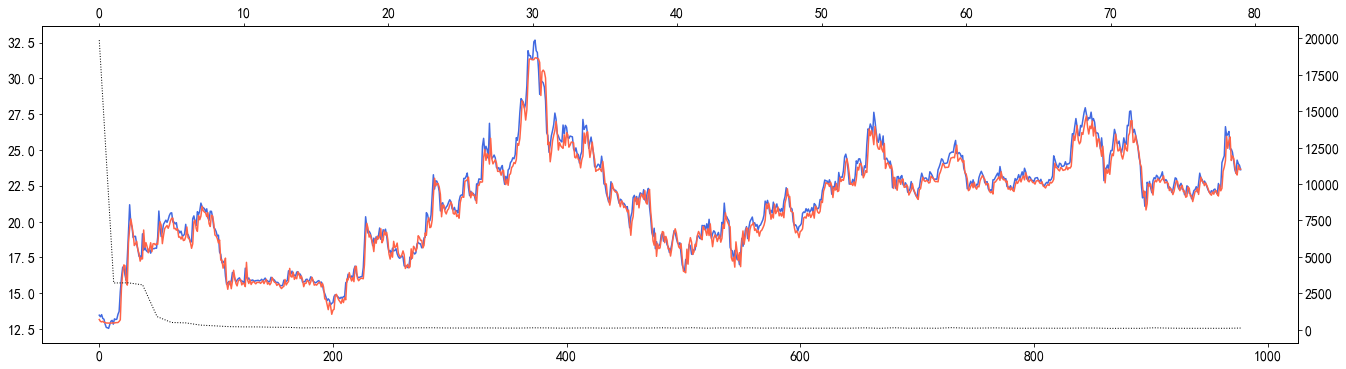

In [25]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=16, num_stacked_layers=3,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

validate loss: 0.31684 ,avg loss: 0.00290683


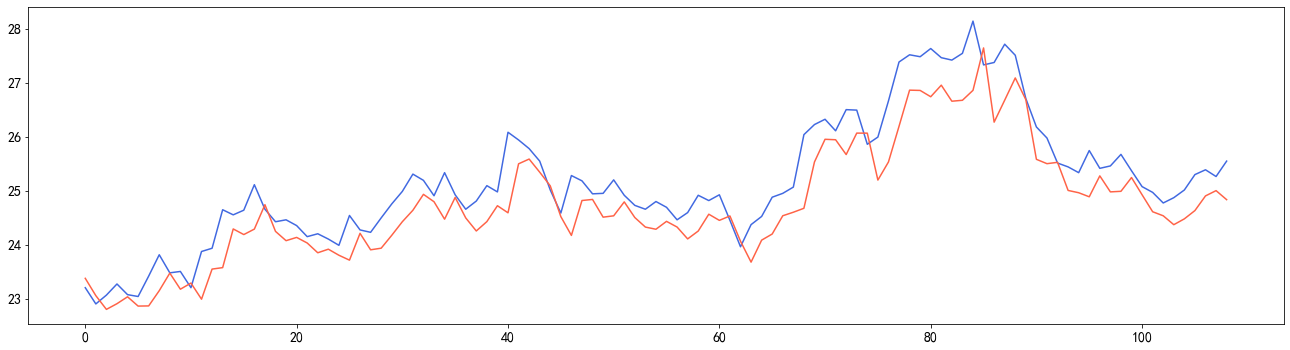

In [26]:
model_check_plot(model, criterion, x_test, y_test)

Training time: 72.89921975135803
validate loss: 13.07980 ,avg loss: 0.01337403


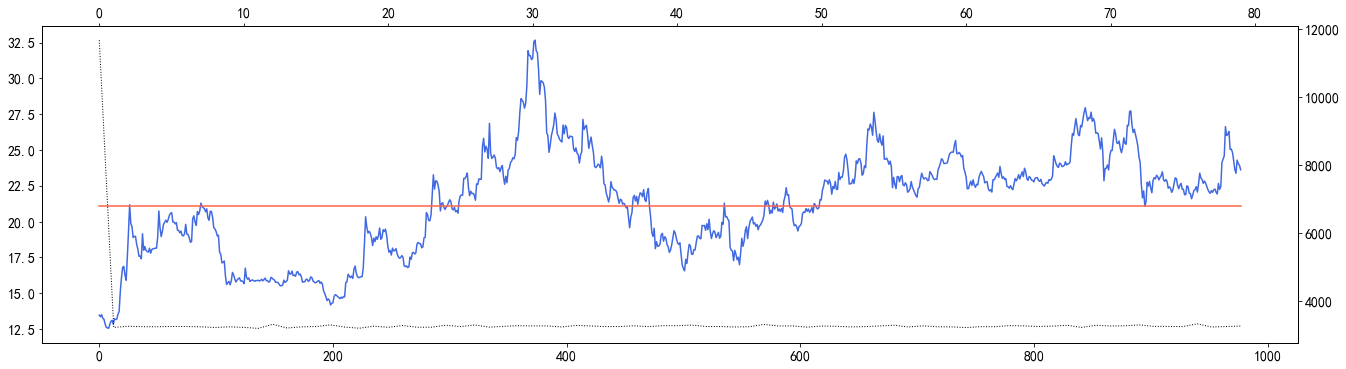

In [29]:
hist = []
model,criterion,_ = lstm_train(train_loader, input_size=1, hidden_size=32, num_stacked_layers=4,
                               model_criterion_optimiser=None,
                               output_size=1, num_epochs=80,historys=hist,verbose=False)
model_check_plot(model, criterion, x_train, y_train, historys=hist)

validate loss: 17.97016 ,avg loss: 0.16486381


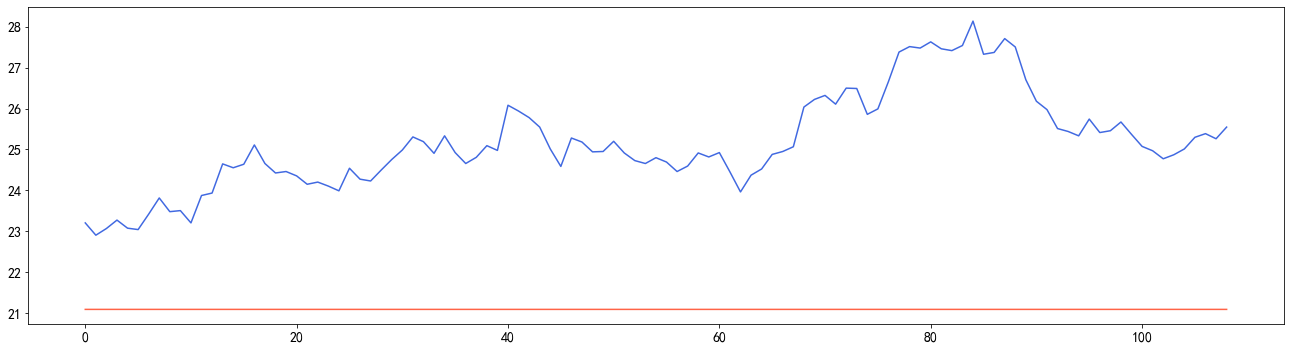

In [30]:
model_check_plot(model, criterion, x_test, y_test)

In [33]:
y_test

tensor([[23.2057],
        [22.9052],
        [23.0683],
        [23.2743],
        [23.0769],
        [23.0425],
        [23.4203],
        [23.8152],
        [23.4804],
        [23.5061],
        [23.2057],
        [23.8753],
        [23.9354],
        [24.6480],
        [24.5535],
        [24.6395],
        [25.1113],
        [24.6573],
        [24.4259],
        [24.4615],
        [24.3547],
        [24.1499],
        [24.2034],
        [24.1054],
        [23.9897],
        [24.5416],
        [24.2746],
        [24.2301],
        [24.4971],
        [24.7553],
        [24.9867],
        [25.3072],
        [25.1914],
        [24.9066],
        [25.3339],
        [24.9244],
        [24.6573],
        [24.8087],
        [25.0935],
        [24.9778],
        [26.0816],
        [25.9392],
        [25.7789],
        [25.5475],
        [25.0134],
        [24.5861],
        [25.2804],
        [25.1825],
        [24.9422],
        [24.9511],
        [25.2003],
        [24.9155],
        [24.

In [31]:
x_test

tensor([[[23.3774],
         [24.2960],
         [24.0470],
         [23.9354],
         [23.6263]],

        [[24.2960],
         [24.0470],
         [23.9354],
         [23.6263],
         [23.2057]],

        [[24.0470],
         [23.9354],
         [23.6263],
         [23.2057],
         [22.9052]],

        [[23.9354],
         [23.6263],
         [23.2057],
         [22.9052],
         [23.0683]],

        [[23.6263],
         [23.2057],
         [22.9052],
         [23.0683],
         [23.2743]],

        [[23.2057],
         [22.9052],
         [23.0683],
         [23.2743],
         [23.0769]],

        [[22.9052],
         [23.0683],
         [23.2743],
         [23.0769],
         [23.0425]],

        [[23.0683],
         [23.2743],
         [23.0769],
         [23.0425],
         [23.4203]],

        [[23.2743],
         [23.0769],
         [23.0425],
         [23.4203],
         [23.8152]],

        [[23.0769],
         [23.0425],
         [23.4203],
         [23.8152],
  